In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from pathlib import Path
from palimpzest.constants import Model, MODEL_CARDS

In [2]:
%load_ext autoreload
%autoreload 2

## Prior

In [91]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

point = "worst"
datapoint = (Model.GPT_4o, (1.0, 2.560178, 0.004451))
bounds = torch.tensor([[2.0/1e7], [7.0/1e6]], dtype=torch.double)
prior_model = SingleTaskGP(
    torch.tensor([[12.5/2e6]]),
    torch.tensor([[datapoint[1][-1]]]),
    input_transform=Normalize(1, bounds = bounds),
    outcome_transform=Standardize(m=1),
)

# prior_model.train()
# prior_model.likelihood.train()
# mll = ExactMarginalLogLikelihood(prior_model.likelihood, prior_model)
# fit_gpytorch_mll(mll) #MAP hyperparameter fitting

/var/folders/ps/3_m2vdps48gf5k41rxpc8h2w0000gn/T/ipykernel_62206/2653664917.py:7: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  prior_model = SingleTaskGP(


## BO experiment results

In [83]:
point = "worst"
budget = 4*100
checkpoint = torch.load(f"bopt-results/gp_full_openai_minCost_{point}_{budget}.pth", weights_only=False)
X = checkpoint['X']
X_models = checkpoint['X_models']
#suggested_points = checkpoint['suggested_points']
Y = checkpoint['Y']
input_transform=checkpoint['input_transform']
outcome_transform=checkpoint['outcome_transform']
loaded_model = SingleTaskGP(
    X,
    Y,
    input_transform=input_transform,
    outcome_transform=outcome_transform
)
loaded_model.load_state_dict(checkpoint['gp_state_dict'])
loaded_model.likelihood.load_state_dict(
    checkpoint['likelihood_state_dict']
)
loaded_model.eval()
loaded_model.likelihood.eval()

from collections import Counter
models_inc_cost = [Model.GPT_4_1_NANO, Model.GPT_5_NANO, Model.GPT_4o_MINI, Model.GPT_4_1_MINI, Model.GPT_5_MINI, Model.GPT_4o_MINI, Model.GPT_4_1, Model.GPT_5, Model.GPT_4o]
print(f"{point} point, {int(budget/4)} observations")
for model in models_inc_cost:
    count = X_models.count(model)
    print(f"{model}: {count}/{int(budget/4)}")

worst point, 100 observations
Model.GPT_4_1_NANO: 0/100
Model.GPT_5_NANO: 0/100
Model.GPT_4o_MINI: 10/100
Model.GPT_4_1_MINI: 5/100
Model.GPT_5_MINI: 14/100
Model.GPT_4o_MINI: 10/100
Model.GPT_4_1: 19/100
Model.GPT_5: 5/100
Model.GPT_4o: 23/100


In [4]:
# gpt_4o = [74.1, 0.008, 12.5/2e6]
# gpt_4o_mini = [62.7, 0.0159, 0.21/2e6]
# gpt_4_1_nano = [62.3, 0.006, 0.5/2e6]
# gpt_4_1_mini = [77.2, 0.0161, 2.0/2e6]
# test_X = torch.tensor([gpt_4o, gpt_4o_mini, gpt_4_1_nano, gpt_4_1_mini], dtype=torch.float64)

# posterior = loaded_model.posterior(test_X)
# print("Predicted mean:", posterior.mean.tolist())
# print("Predicted variance:", posterior.variance.tolist())

### 3d domain space

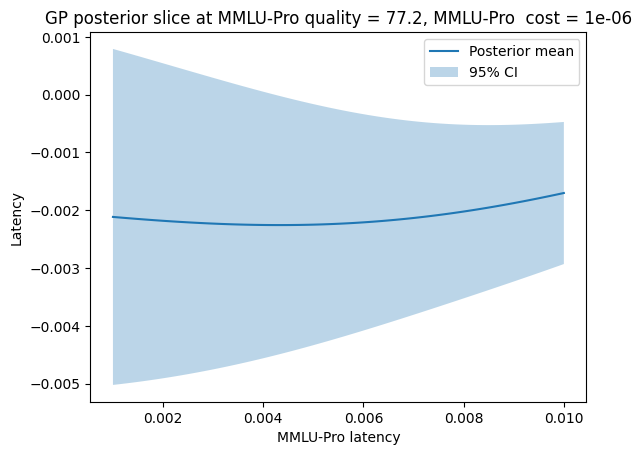

In [ ]:

n = 100
# x1 = torch.linspace(60, 90, n)
# x2_fixed = 0.0161
# x3_fixed = 2.0/2e6

# X = torch.stack(
#     [x1, torch.full_like(x1, x2_fixed), torch.full_like(x1, x3_fixed)],
#     dim=-1
# )  # shape: (n, 3)

x1_fixed = 77.2
x2 = torch.linspace(0.001, 0.01, n)
x3_fixed = 2.0/2e6

X = torch.stack(
    [torch.full_like(x2, x1_fixed), x2, torch.full_like(x2, x3_fixed)],
    dim=-1
)  # shape: (n, 3)

with torch.no_grad():
    posterior = loaded_model.posterior(X)
mean = posterior.mean.squeeze(-1)
std  = posterior.variance.sqrt().squeeze(-1)

import matplotlib.pyplot as plt

plt.figure()

# Posterior mean
plt.plot(x2.cpu(), mean.cpu(), label="Posterior mean")

# Confidence band (±2σ)
plt.fill_between(
    x2.cpu(),
    (mean - 2 * std).cpu(),
    (mean + 2 * std).cpu(),
    alpha=0.3,
    label="95% CI",
)

plt.xlabel("MMLU-Pro latency")
plt.ylabel("Latency")
plt.title(f"GP posterior slice at MMLU-Pro quality = {x1_fixed}, MMLU-Pro  cost = {x3_fixed}")
plt.legend()
plt.show()


In [68]:
print(suggested_points)

tensor([[6.2300e+01, 6.0000e-03, 2.5000e-07],
        [8.8400e+01, 2.0000e-02, 7.0000e-06],
        [9.0000e+01, 2.0000e-02, 2.0000e-07],
        [6.0000e+01, 2.0000e-02, 7.0000e-06],
        [9.0000e+01, 2.0000e-02, 7.0000e-06],
        [9.0000e+01, 2.0000e-02, 7.0000e-06],
        [6.0000e+01, 2.0000e-02, 7.0000e-06],
        [6.0000e+01, 2.0000e-02, 3.1874e-06],
        [6.0000e+01, 2.0000e-02, 3.9242e-06],
        [6.0000e+01, 2.0000e-02, 3.2642e-06],
        [6.0000e+01, 2.0000e-02, 7.0000e-06]], dtype=torch.float64)


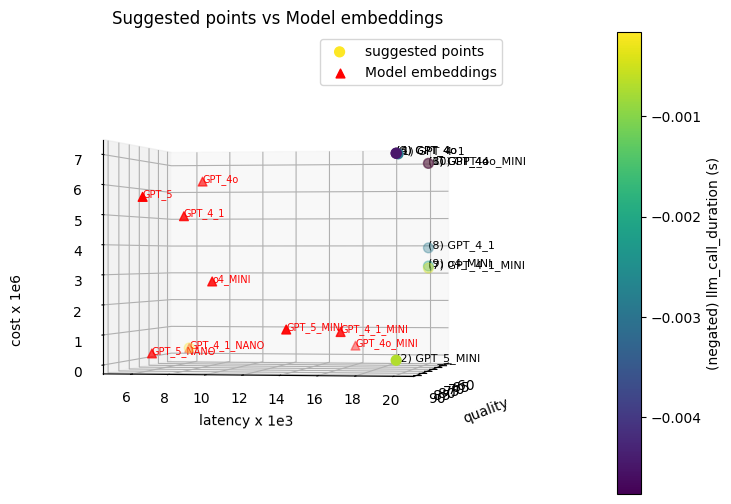

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# ---------- First dataset (X) ----------
X_np = np.array(suggested_points)
x1 = X_np[:, 0]
y1 = X_np[:, 1] * 1e3
z1 = X_np[:, 2] * 1e6

# ---------- Second dataset (embedding) ----------
embedding = []
models = [Model.GPT_4o, Model.GPT_4o_MINI, Model.GPT_4_1, Model.GPT_4_1_MINI, Model.GPT_4_1_NANO,
                Model.GPT_5, Model.GPT_5_MINI, Model.GPT_5_NANO, Model.o4_MINI]
for model in models:
    model_card = MODEL_CARDS[model]
    domain_point = [model_card["overall"],
                    model_card["seconds_per_output_token"],
                    (model_card["usd_per_input_token"] + model_card["usd_per_output_token"])/2]
    embedding.append(domain_point)
embedding = torch.tensor(embedding)
embedding_np = embedding.detach().cpu().numpy()
x2 = embedding_np[:, 0]
y2 = embedding_np[:, 1] * 1e3
z2 = embedding_np[:, 2] * 1e6

# ---------- Plot ----------
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')

# First scatter (colored by Y)
sc1 = ax.scatter(
    x1, y1, z1,
    c=Y,
    cmap='viridis',
    s=50,
    marker='o',
    label='suggested points'
)

# Second scatter (constant color / different marker)
sc2 = ax.scatter(
    x2, y2, z2,
    color='red',
    s=40,
    marker='^',
    label='Model embeddings'
)

# Colorbar for first dataset
cbar = plt.colorbar(sc1, ax=ax, pad=0.1)
cbar.set_label('(negated) llm_call_duration (s)')

# ---------- Labels: dataset 1 ----------
num_start = 1

order = [0]*num_start + list(range(1, len(X_models)-num_start+1))
for xi, yi, zi, label, num in zip(x1, y1, z1, X_models, order):
    if num < 1:
        continue
        ax.text(xi, yi, zi, f"({num}) ", fontsize=8)
    else:
        ax.text(xi, yi, zi, f"({num}) {str(label)[6:]} ", fontsize=8)

# ---------- Labels: dataset 2 ----------
for xi, yi, zi, label in zip(x2, y2, z2, models):
    ax.text(xi, yi, zi, str(label)[6:], fontsize=7, color='red')

# ---------- Axes ----------
ax.set_xlabel('quality', labelpad=10)
ax.set_ylabel('latency x 1e3', labelpad=10)

ax.text2D(
    -0.08, 0.4,
    'cost x 1e6',
    transform=ax.transAxes,
    rotation=90,
    va='center'
)

ax.set_title('Suggested points vs Model embeddings')
ax.view_init(elev=0, azim=10)

ax.legend()
plt.show()


In [ ]:
# posterior mean heatmap
quality_min, quality_max = 60.0, 90.0
cost_min, cost_max = 2.0/1e7, 7.0/1e6

n = 150  # grid density
quality_linespace = torch.linspace(quality_min, quality_max, n)
cost_linespace = torch.linspace(cost_min, cost_max, n)
X0, X1 = torch.meshgrid(quality_linespace, cost_linespace, indexing="ij")

latency_fixed = 0.01
X = torch.zeros(n * n, 3)
X[:, 0] = X0.reshape(-1)
X[:, 1] = X1.reshape(-1)
X[:, 2] = latency_fixed

model.eval()
with torch.no_grad():
    posterior = model.posterior(X)
    mean = posterior.mean.squeeze(-1)  # shape: (n*n,)
Z = mean.reshape(n, n).cpu().numpy()

plt.figure(figsize=(6, 5))
im = plt.imshow(
    Z,
    extent=(quality_min, quality_max, cost_min, cost_max),
    origin="lower",
    aspect="auto"
)
plt.colorbar(im, label="Posterior mean")
plt.xlabel("Quality")
plt.ylabel("Cost")
plt.title(f"GP Posterior Mean (Latency = {latency_fixed})")
plt.show()

#TODO: add observed points


### 1d domain space

<Figure size 800x500 with 0 Axes>

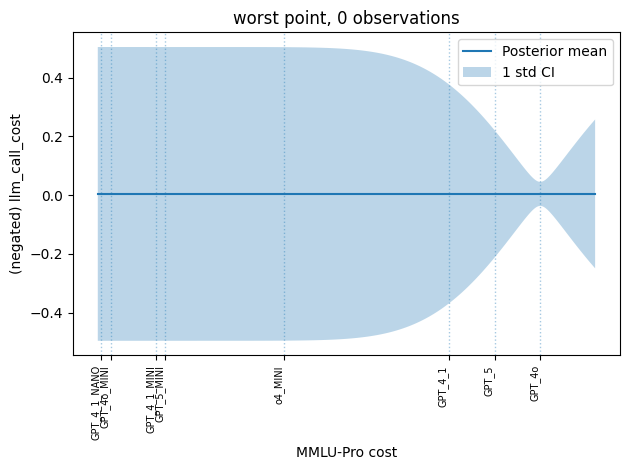

In [97]:
import torch
import matplotlib.pyplot as plt

# ---- Dense grid over bounds ----
n_grid = 500
x_grid = torch.linspace(2.0/1e7, 7.0/1e6, n_grid).unsqueeze(-1)

with torch.no_grad():
    posterior = prior_model.posterior(x_grid)
    mean = posterior.mean.squeeze(-1)
    std = posterior.variance.sqrt().squeeze(-1)

lower = mean - 0.5 * std
upper = mean + 0.5 * std

# ---- Plot ----
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()

# Posterior mean
plt.plot(
    x_grid.squeeze().numpy(),
    mean.numpy(),
    label="Posterior mean",
)

# Confidence interval
plt.fill_between(
    x_grid.squeeze().numpy(),
    lower.numpy(),
    upper.numpy(),
    alpha=0.3,
    label="1 std CI",
)

# Observed points
# plt.scatter(
#     X.squeeze().numpy(),
#     Y.squeeze().numpy(),
#     color="black",
#     s=30,
#     zorder=3,
#     label="Observations",
#     alpha = 0.4
# )
# # Annotate each point
# num_start = 1
# labels = [0]*num_start + list(range(1, len(X_models)-num_start+1))
# for xi, yi, model, label in zip(X, Y, X_models, labels):
#     plt.annotate(
#         f"{label}",
#         (xi, yi),
#         xytext=(5, 5),          # offset in points
#         textcoords="offset points",
#         fontsize=8,
#         ha="left",
#         va="bottom",
#         alpha = 1,
#         zorder=10
#     )

# Model locations ----------------
models = [Model.GPT_4o, Model.GPT_4o_MINI, Model.GPT_4_1, Model.GPT_4_1_MINI, Model.GPT_4_1_NANO,
                Model.GPT_5, Model.GPT_5_MINI, Model.o4_MINI] #Model.GPT_5_NANO ≈ 4.1 nano
model_names = []
mmlu_costs = []
for model in models:
    model_card = MODEL_CARDS[model]
    mmlu_costs.append((model_card["usd_per_input_token"] + model_card["usd_per_output_token"])/2)
    model_names.append(str(model)[6:])
    
plt.xticks(mmlu_costs, model_names, rotation = 90, fontsize = 7, ha = "right")
for xv in mmlu_costs:
    ax.axvline(
        xv,
        linestyle=":",
        linewidth=1,
        alpha=0.4,
        zorder=0,
    )
# --------------------

plt.xlabel("MMLU-Pro cost")
plt.ylabel("(negated) llm_call_cost")
#plt.ylim((-0.01, 0.01))
plt.title(f"{point} point, {int(0/4)} observations")
plt.legend()
plt.tight_layout()
plt.show()


## Explore Domain Space

In [14]:
from palimpzest.constants import Model, MODEL_CARDS

In [39]:
domain_points = []
for model in Model:
    if not model.is_openai_model() and not model.is_together_model():
        continue
    model_card = MODEL_CARDS[model]
    input_cost = model_card["usd_per_input_token"] if "usd_per_input_token" in model_card else None
    output_cost = model_card["usd_per_output_token"] if "usd_per_output_token" in model_card else None
    if input_cost is None and output_cost is None:
        print(f"Skipping {model}, missing cost data")
        continue
    elif input_cost is None:
        avg_cost = output_cost
    elif output_cost is None:
        avg_cost = input_cost
    else:
        avg_cost = 0.5 * (input_cost + output_cost)
    x = [
        model_card["overall"],
        model_card["seconds_per_output_token"],
        avg_cost
    ]
    domain_points.append(x)
domain_points = torch.tensor(domain_points)
print(domain_points)

tensor([[3.6500e+01, 7.9000e-03, 6.0000e-08],
        [4.4250e+01, 5.0000e-03, 1.8000e-07],
        [6.9900e+01, 1.2200e-02, 8.8000e-07],
        [7.3800e+01, 1.1400e-02, 1.2500e-06],
        [3.9900e+01, 5.0000e-03, 1.8000e-07],
        [7.4100e+01, 8.0000e-03, 6.2500e-06],
        [6.2700e+01, 1.5900e-02, 3.7500e-07],
        [8.0500e+01, 7.6000e-03, 5.0000e-06],
        [7.7200e+01, 1.6100e-02, 1.0000e-06],
        [6.2300e+01, 6.0000e-03, 2.5000e-07],
        [8.7000e+01, 6.0000e-03, 5.6250e-06],
        [8.2500e+01, 1.3500e-02, 1.1250e-06],
        [7.7900e+01, 5.5000e-03, 2.2500e-07],
        [8.0600e+01, 9.2000e-03, 2.7500e-06],
        [7.4100e+01, 8.0000e-03, 1.0000e-05],
        [6.2700e+01, 1.5900e-02, 6.0000e-07],
        [6.3090e+01, 9.8000e-03, 2.0000e-08],
        [6.3300e+01, 9.8000e-03, 0.0000e+00]])


In [40]:
bounds = torch.tensor([
            [0.0, 0, 0.0],
            [100.0, 0.1, 30.0/1e6]
        ])
normalizer = Normalize(d = 3)
domain_transformed = normalizer(domain_points)
print(domain_transformed, len(domain_points))

tensor([[0.0000, 0.2613, 0.0060],
        [0.1535, 0.0000, 0.0180],
        [0.6614, 0.6486, 0.0880],
        [0.7386, 0.5766, 0.1250],
        [0.0673, 0.0000, 0.0180],
        [0.7446, 0.2703, 0.6250],
        [0.5188, 0.9820, 0.0375],
        [0.8713, 0.2342, 0.5000],
        [0.8059, 1.0000, 0.1000],
        [0.5109, 0.0901, 0.0250],
        [1.0000, 0.0901, 0.5625],
        [0.9109, 0.7658, 0.1125],
        [0.8198, 0.0450, 0.0225],
        [0.8733, 0.3784, 0.2750],
        [0.7446, 0.2703, 1.0000],
        [0.5188, 0.9820, 0.0600],
        [0.5265, 0.4324, 0.0020],
        [0.5307, 0.4324, 0.0000]]) 18


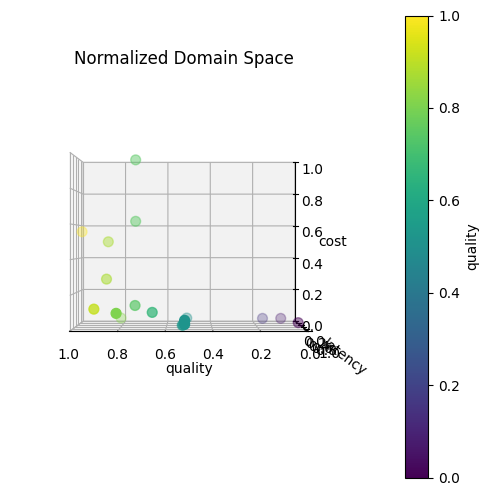

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
import numpy as np

# Convert list of tuples to numpy array
points_array = np.array(domain_transformed)
x, y, z = points_array[:,0], points_array[:,1], points_array[:,2]

# Create 3D plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=x, cmap='viridis', s=50)  # c=color, s=size
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('quality')

# Optional: set axes limits to unit cube
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)

ax.set_xlabel('quality')
ax.set_ylabel('latency')
ax.set_zlabel('cost')
ax.set_title('Normalized Domain Space')
ax.view_init(elev=0, azim=90)  # elev=height, azim=rotation

plt.show()


## gpt Model Performances

In [29]:
import pandas as pd
df = pd.read_csv("gpt_email_results.csv")

In [30]:
df_avg = df.groupby("model").mean()

In [34]:
print(df_avg[['quality', 'llm_call_duration_secs', 'total_cost']].sort_values(by = 'total_cost'))

                                quality  llm_call_duration_secs  total_cost
model                                                                      
openai/gpt-4.1-nano-2025-04-14      1.0                1.449226    0.000157
openai/gpt-5-nano-2025-08-07        1.0                3.341086    0.000191
openai/gpt-4o-mini-2024-07-18       1.0                3.205636    0.000246
openai/gpt-4.1-mini-2025-04-14      1.0                1.149936    0.000474
openai/gpt-5-mini-2025-08-07        1.0                4.553895    0.000726
openai/o4-mini-2025-04-16           1.0                2.929694    0.002221
openai/gpt-4.1-2025-04-14           1.0                1.457867    0.002914
openai/gpt-5-2025-08-07             1.0                3.395675    0.003320
openai/gpt-4o-2024-08-06            1.0                2.560178    0.004451


In [32]:
cost = []
embedding = []
models = [Model.GPT_4o, Model.GPT_4o_MINI, Model.GPT_4_1, Model.GPT_4_1_MINI, Model.GPT_4_1_NANO,
                Model.GPT_5, Model.GPT_5_MINI, Model.GPT_5_NANO, Model.o4_MINI]
for model in models:
    cost.append(df_avg.loc[model, 'total_cost'])
    model_card = MODEL_CARDS[model]
    domain_point = [model_card["overall"],
                    model_card["seconds_per_output_token"],
                    (model_card["usd_per_input_token"] + model_card["usd_per_output_token"])/2]
    embedding.append(domain_point)
embedding = torch.tensor(embedding)
normalizer = Normalize(d = 3)
embedding_normalized = normalizer(embedding)

In [37]:
print(embedding)

tensor([[7.4100e+01, 8.0000e-03, 6.2500e-06],
        [6.2700e+01, 1.5900e-02, 3.7500e-07],
        [8.0500e+01, 7.6000e-03, 5.0000e-06],
        [7.7200e+01, 1.6100e-02, 1.0000e-06],
        [6.2300e+01, 6.0000e-03, 2.5000e-07],
        [8.7000e+01, 6.0000e-03, 5.6250e-06],
        [8.2500e+01, 1.3500e-02, 1.1250e-06],
        [7.7900e+01, 5.5000e-03, 2.2500e-07],
        [8.0600e+01, 9.2000e-03, 2.7500e-06]])


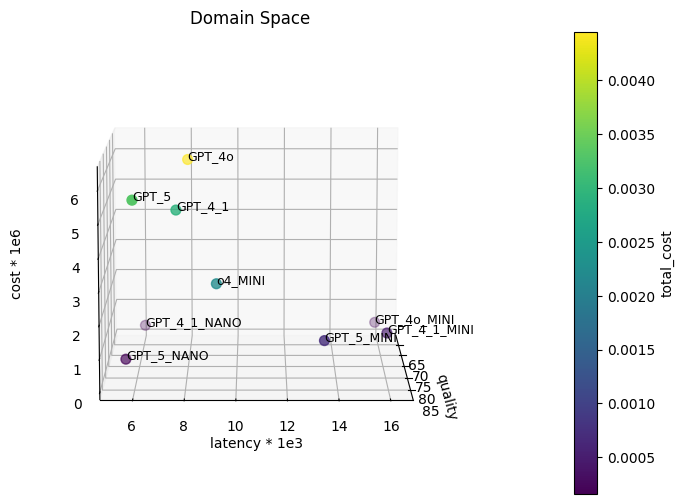

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
import numpy as np

# Convert list of tuples to numpy array
points_array = np.array(embedding)
x, y, z = points_array[:,0], points_array[:,1]*1e3, points_array[:,2]*1e6

# Create 3D plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=cost, cmap='viridis', s=50)  # c=color, s=size
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('total_cost')

for xi, yi, zi, label in zip(x, y, z, models):
    ax.text(
        xi, yi, zi, str(label)[6:],
        fontsize=9
    )


# Optional: set axes limits to unit cube
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# ax.set_zlim(0,1)

ax.set_xlabel('quality')
ax.set_ylabel('latency * 1e3')
# Manual z-axis label (robust)
ax.text2D(
    -0.02, 0.5,
    'cost * 1e6',
    transform=ax.transAxes,
    rotation=90,
    va="center"
)
ax.set_title('Domain Space')
ax.view_init(elev=10, azim=0)

plt.show()
